# Inference of hierarchical Gaussian model parameters

In [14]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pints
import scipy.stats
import seaborn as sns
import xarray as xr
sns.set_theme()

The data-generating distribution is
$$
    y \sim p(\cdot | \mu _{\mathrm{pop}}) =
    \int \mathrm{d}\mu \, \mathcal{N}(y | \mu, 1)\,
    \mathcal{N}(\mu | \mu _{\mathrm{pop}}, 1)
$$

Due to the conjugacy of Gaussian distributions, the hierarchical distribution
can be computed exactly to be

$$
    y \sim \mathcal{N}(\cdot | \mu _{\mathrm{pop}}, 2).
$$

Together with
a Gaussian prior $\mu _{\mathrm{pop}} \sim \mathcal{N}(\cdot | \mu _0 = 0, \sigma _0^2 = 16)$, we
can also use the conjugacy to compute the posterior
distribution analytically
$$
    p(\mu _{\mathrm{pop}} | \mathcal{D}) =
        \mathcal{N}(\mu _{\mathrm{pop}} | \mu ', \sigma '^2 ),
$$
where
$$
    \mu' = \sigma '^2\frac{n\bar{y}}{2},
    \quad
    \sigma '^2 = \frac{16}{1 + 8n}.
$$
Here, $n$ is the number of snapshot observations in the dataset
$\mathcal{D}=\{y_j^{\mathrm{obs}}\}$ and $\bar{y}$ denotes the empirical mean,
$\bar{y} = \sum _j y_j^{\mathrm{obs}} / n$.

# Synthesise data

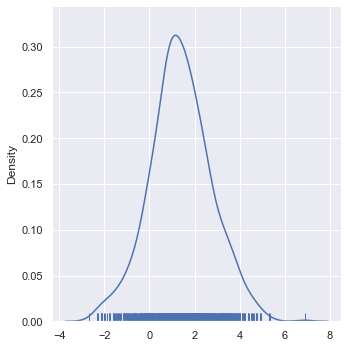

In [5]:
np.random.seed(42)
n_ids = 1000
n_samples_per_id = 1
true_parameters = [1.3, 1, 1]  # pop mean, pop std., noise
means = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids)
data = np.empty(shape=(n_ids, n_samples_per_id))
for ids, mean in enumerate(means):
    data[ids] = np.random.normal(
    loc=mean, scale=true_parameters[2], size=n_samples_per_id)

sns.displot(data.flatten(), kind='kde', rug=True)
plt.show()

## Define log-likelihoods

1. Exact Gaussian log-likelihood
2. Gaussian filter log-likelihood
3. Gaussian KDE filter log-likelihood
4. Gaussian KDE filter log-likelihood with rank matching 
4. Data-centric KDE filter log-likelihood

In [144]:
class ExactHierarchicalLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations
        self._n_ids, self._n_obs = observations.shape
        self._error_model = chi.GaussianErrorModel()
        self._pop_model = chi.GaussianModel()

    def __call__(self, parameters):
        # Compute population contribution
        means = parameters[:self._n_ids]
        pop_mean = parameters[self._n_ids]
        pop_sigma, sigma = [1, 1]
        score = np.sum(
            scipy.stats.norm(loc=pop_mean, scale=pop_sigma).logpdf(
                means))
        if np.isinf(score):
            return score

        # Compute contributions from individual log-likelihoods
        for _id, mean in enumerate(means):
            score += np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations[_id]))

        return score

    def evaluateS1(self, parameters):
        # Compute population contribution
        means = np.array(parameters[:self._n_ids])
        pop_mean = parameters[self._n_ids]
        pop_sigma, sigma = [1, 1]
        score, pop_sens = self._pop_model.compute_sensitivities(
            parameters=[pop_mean, pop_sigma], observations=means)

        # Compute individual contributions
        sensitivities = np.zeros(self.n_parameters())
        for _id, indiv_obs in enumerate(self._observations):
            s, sens = self._error_model.compute_sensitivities(
                parameters=[sigma],
                model_output=np.array([means[_id]] * self._n_obs),
                model_sensitivities=np.ones(shape=(self._n_obs, 1)),
                observations=indiv_obs)

            score += s
            sensitivities[_id] += sens[0]

        # Add population sensitivities
        sensitivities += pop_sens[:-1]

        return score, sensitivities

    def n_parameters(self):
        return self._n_ids + 1

    def get_parameter_names(self):
        return ['Mean'] * self._n_ids + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_ids)] + [None]


class GaussianFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = np.array(observations).flatten()
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        standard_mean_samples = np.array(
            parameters[:self._n_samples])[:, np.newaxis]
        standard_noise_samples = np.array(
            parameters[self._n_samples:2*self._n_samples])[np.newaxis, :]
        pop_mean = parameters[-1]
        pop_std, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mean + standard_mean_samples * pop_std
        measurements = mean_samples + sigma * standard_noise_samples

        # Estimate population mean and population std from samples
        pop_mu = np.mean(measurements)
        pop_sigma = np.std(measurements, ddof=1)
        score = np.sum(
            scipy.stats.norm(loc=pop_mu, scale=pop_sigma).logpdf(
                self._observations))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = pop_sigma / self._n_samples
        dpop_mu_hat_depsilon = sigma / self._n_samples
        dpop_mu_hat_dpop_mu = 1
        dpop_mu_hat_dpop_sigma = np.mean(eta)
        dpop_sigma_hat_deta = \
            pop_sigma * (measurements - pop_mu_hat) / (self._n_samples - 1) \
            / pop_sigma_hat
        dpop_sigma_hat_depsilon = \
            sigma * (measurements - pop_mu_hat) / (self._n_samples - 1) / \
            pop_sigma_hat
        dpop_sigma_hat_dpop_mu = 0

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu,
            dpop_mu_hat_dpop_sigma]), shape=(n_obs, 4))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[0] + sens[-1] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[1] + sens[-1] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[2] + sens[-1] * dpop_sigma_hat_dpop_mu

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return [
            'Mean eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class GaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_samples) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        # p = log mean exp scores
        # dp/dmean = exp(score) / sum(exp(scores)) * dscore / dmean
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        # dp/dpop_mean = exp(score) / sum(exp(scores)) * dscore / dpop_mean
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - pop_sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax,
                axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax,
                axis=0)
        sensitivities[2*self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax)

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return ['Mean eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class RankMatchingGaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000):
        # Make sure n_obs is a multiple of n_samples
        n_samples = int(n_samples)
        if len(observations) % n_samples != 0:
            raise ValueError(
                'n_samples has to be a divisor of n_observations.')

        # Rank observations and rearrange into blocks of n_obs / n_samples
        n_block = int(len(observations) / n_samples)
        self._observations = np.sort(observations.flatten()).reshape(
            (n_samples, n_block))
        self._n_samples = n_samples

        # Set kernel scale
        # (Each block gets its own kernel)
        kernel_scale = np.zeros(n_samples)
        if len(observations) > n_samples:
            kernel_scale = \
                np.std(self._observations, ddof=1, axis=1) \
                * (4 / 3) ** (0.2)
        self._kernel_scale = kernel_scale[:, np.newaxis]

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                measurements[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                measurements[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        # Collect sensitivities
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - np.sum(pop_sigma / kernel_var *
                (measurements[:, np.newaxis] - self._observations), axis=1)
        sensitivities[self._n_samples] = \
            -  np.sum(1 / kernel_var *
                (measurements[:, np.newaxis] - self._observations))

        return score, sensitivities

    def n_parameters(self):
        return self._n_samples + 1

    def get_parameter_names(self):
        return ['Mean eta'] * self._n_samples + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] + [None]


class DataCentricGaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(
        self, observations, n_samples=1, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_obs = len(self._observations)
        self._n_samples = int(n_samples) if n_samples >= 1 else 1
        self._factor = self._n_obs / self._n_samples

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_obs) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        mu = parameters[:self._n_samples]
        epsilon = parameters[self._n_samples:2*self._n_samples]
        sigma = 1
        measurement = mu + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        score = self._factor * np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale)
            - (measurement[np.newaxis, :]
            - self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=0) - np.log(self._n_obs))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        mu = parameters[:self._n_samples]
        epsilon = parameters[self._n_samples:2*self._n_samples]
        sigma = 1
        measurement = mu + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) \
            - (measurement[np.newaxis, :] \
            - self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = self._factor * np.sum(
            scipy.special.logsumexp(scores, axis=0) - np.log(self._n_obs))

        # Collect sensitivities
        # p = log mean exp scores
        # dp/dmu = exp(score) / sum(exp(scores)) * dscore / dmean
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        softmax = \
            np.exp(scores - np.max(scores, axis=0)[np.newaxis, :]) \
            / np.sum(np.exp(scores - np.max(scores, axis=0)[np.newaxis, :]),
            axis=0)[np.newaxis, :]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = self._factor * \
            - 1 / self._kernel_scale**2 \
            * np.sum((measurement[np.newaxis, :]
            - self._observations[:, np.newaxis]) * softmax, axis=0)

        sensitivities[self._n_samples:2*self._n_samples] = self._factor * \
            - sigma / self._kernel_scale**2 \
            * np.sum((measurement[np.newaxis, :]
            - self._observations[:, np.newaxis]) * softmax, axis=0)

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples

    def get_parameter_names(self):
        return ['Mean'] * self._n_samples + ['Epsilon'] * self._n_samples

    def get_id(self):
        return ['ID %d' % (_id+1) for _id in range(self._n_samples)] * 2

## Inference

### 1. Exact likelihood

In [ ]:
n_ids = 1000
log_likelihood = ExactHierarchicalLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-20, 20)] * n_ids + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
controller._initial_params[0, 0, :n_ids] = means
controller._initial_params[0, 0, -1] = 1
n_iterations = 1500
exact_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    exact_posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

In [42]:
exact_posterior_samples.to_netcdf(
    'derived_data/posteriors/hierarchical_gaussian_model_exact.nc')

In [17]:
exact_posterior_samples = xr.load_dataset(
    'derived_data/posteriors/hierarchical_gaussian_model_exact.nc')

### 2. Gaussian filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     4      0.25     1        0:00.0
1     5      0.25     1        0:00.0
2     6      0.25     1        0:00.0
3     9      0.5      2        0:00.0
20    2062   0.747    115      0:01.1
40    4230   0.757    104      0:02.1
60    6344   0.735    101      0:03.1
80    8161   0.777    87       0:03.8
100   9608   0.768    69       0:04.4
120   11034  0.723    68       0:05.1
140   12778  0.762    84       0:05.8
160   14657  0.73     90       0:06.6
180   16440  0.728    85       0:07.3
200   18283  0.776    88       0:08.0
220   20111  0.768967 88       0:08.8
240   21279  0.745    56       0:09.2
260   23212  0.726718 92       0:10.0
280   24920  0.752    82       0:10.7
300   26302  0.764    66       0:11.3
320   27533  0.757    59       0:11.8
340   28643  0.754    53       0:12.2
360   30023  0.749    66       0:12.8
380   31170  0.772    55       0:13.2
400   32474  0.758

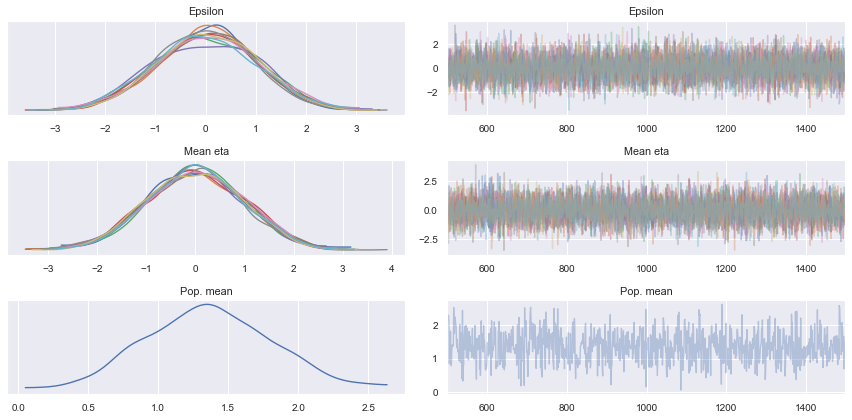

In [19]:
n_samples = 10
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_10_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.0
2     7      0.25     1        0:00.0
3     8      0.25     1        0:00.0
20    2352   0.746    131      0:02.4
40    4521   0.762989 104      0:04.5
60    6552   0.753    97       0:06.6
80    8399   0.755199 88       0:08.4
100   9839   0.75     69       0:09.9
120   10424  0.74     28       0:10.5
140   10932  0.752    25       0:11.0
160   11446  0.738    25       0:11.5
180   11982  0.762    26       0:12.1
200   12530  0.735    27       0:12.6
220   12945  0.771    20       0:13.0
240   13357  0.761    20       0:13.5
260   13721  0.704    18       0:13.8
280   14218  0.757    24       0:14.3
300   14798  0.761    28       0:14.9
320   15250  0.748    22       0:15.3
340   15614  0.744    18       0:15.8
360   16042  0.767689 21       0:16.2
380   16454  0.763    20       0:16.6
400   16850  0.752

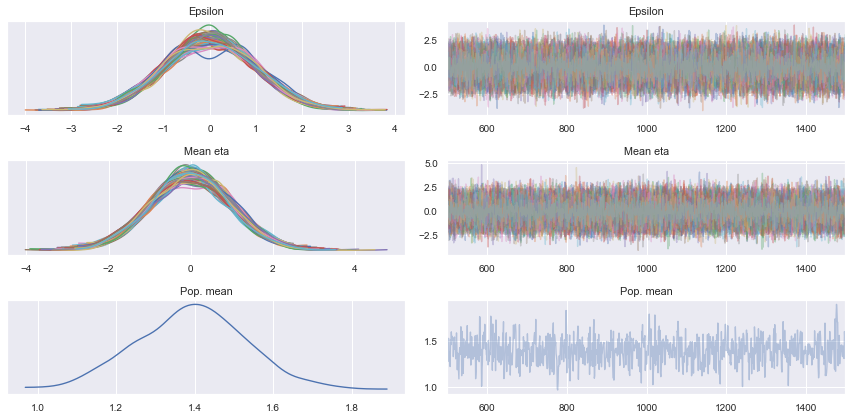

In [20]:
n_samples = 100
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.1
1     6      0.25     1        0:00.1
2     7      0.25     1        0:00.1
3     8      0.25     1        0:00.1
20    1696   0.762    94       0:12.0
40    4126   0.748    116      0:28.9
60    5854   0.769    83       0:41.1
80    7705   0.747    89       0:54.6
100   9321   0.757    77       1:05.5
120   9773   0.702945 22       1:08.6
140   10297  0.757    25       1:12.1
160   10699  0.72     20       1:14.9
180   11095  0.745    19       1:17.6
200   11579  0.759    24       1:20.8
220   12039  0.773    22       1:23.9
240   12451  0.758    20       1:26.7
260   12769  0.696    16       1:28.9
280   13237  0.758    23       1:32.4
300   13649  0.755    20       1:35.4
320   14061  0.743    20       1:38.1
340   14377  0.772    16       1:40.2
360   14757  0.753    19       1:42.7
380   15121  0.739    18       1:45.3
400   15549  0.767

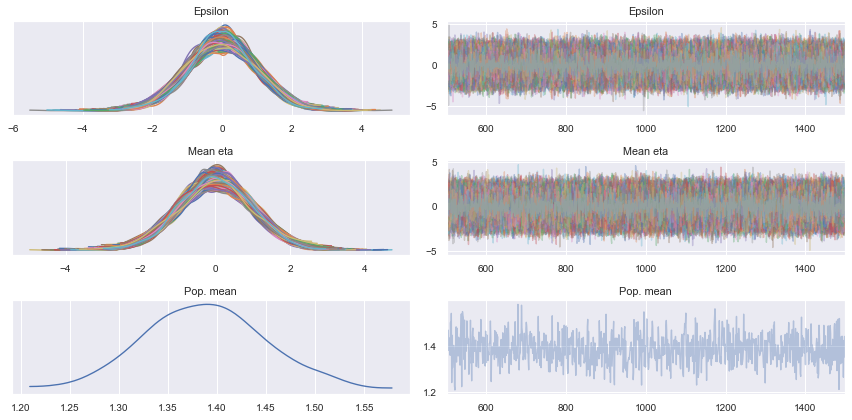

In [21]:
n_samples = 1000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

10000 samples

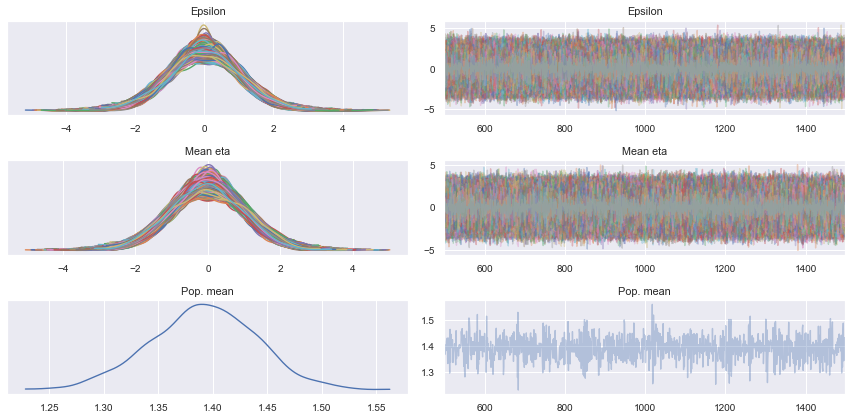

In [62]:
n_samples = 10000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10000_posterior_samples = controller.run(
    n_iterations=n_iterations)

warmup=500
az.plot_trace(
    gaussian_filter_10000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [63]:
gaussian_filter_10000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_gaussian_model_gaussian_filter_10000.nc')

In [22]:
gaussian_filter_10000_posterior_samples = xr.load_dataset(
    'derived_data/posteriors/'
    'hierarchical_gaussian_model_gaussian_filter_10000.nc')

### 3. Gaussian KDE filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     6      0.25     1        0:00.0
1     7      0.25     1        0:00.0
2     8      0.25     1        0:00.0
3     9      0.25     1        0:00.0
20    2492   0.751    138      0:02.1
40    5011   0.761    120      0:04.3
60    6941   0.741    92       0:05.9
80    8866   0.755    92       0:07.4
100   10467  0.744    77       0:08.7
120   11834  0.731    66       0:09.8
140   14104  0.743    109      0:11.7
160   15597  0.716    71       0:13.0
180   16929  0.764    64       0:14.1
200   18413  0.725    71       0:15.4
220   20024  0.767    77       0:16.7
240   21311  0.766    62       0:17.7
260   22361  0.700287 50       0:18.6
280   23854  0.766    72       0:19.7
300   25310  0.749    70       0:20.9
320   26354  0.745    50       0:21.7
340   27438  0.764    52       0:22.6
360   28384  0.761    46       0:23.3
380   29473  0.762    52       0:24.2
400   30611  0.753

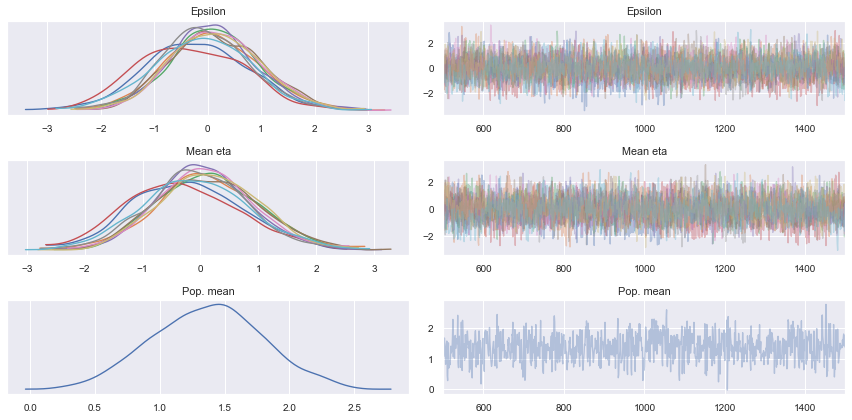

In [8]:
n_samples = 10
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.1
2     7      0.25     1        0:00.1
3     9      0.167    1        0:00.1
20    1731   0.787    96       0:07.1
40    4107   0.738    114      0:15.5
60    6038   0.769    92       0:22.9
80    7579   0.75     74       0:28.8
100   9193   0.766    77       0:34.6
120   9916   0.709    35       0:37.3
140   10696  0.751    38       0:40.2
160   11547  0.722    41       0:43.6
180   12399  0.743    41       0:47.2
200   13243  0.758    41       0:50.9
220   13959  0.74     35       0:53.2
240   14739  0.768    38       0:56.6
260   15430  0.718    33       0:59.6
280   16274  0.776    41       1:03.1
300   16926  0.759    32       1:05.3
320   17578  0.746    32       1:07.5
340   18150  0.768    28       1:09.5
360   18642  0.752    24       1:11.2
380   19166  0.741    25       1:13.0
400   19706  0.779

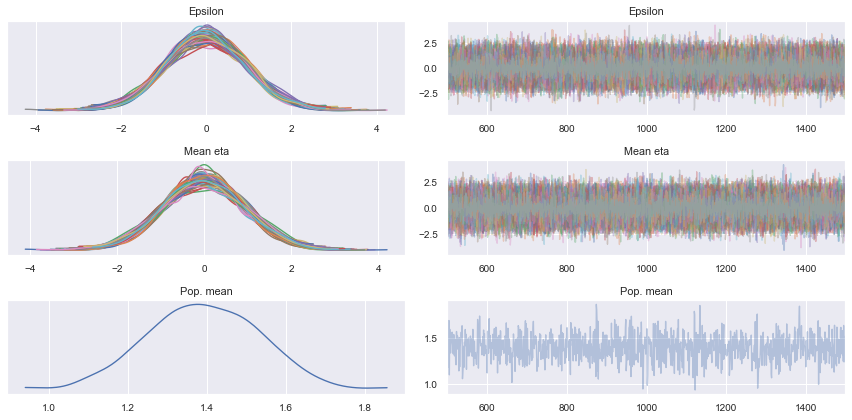

In [10]:
n_samples = 100
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


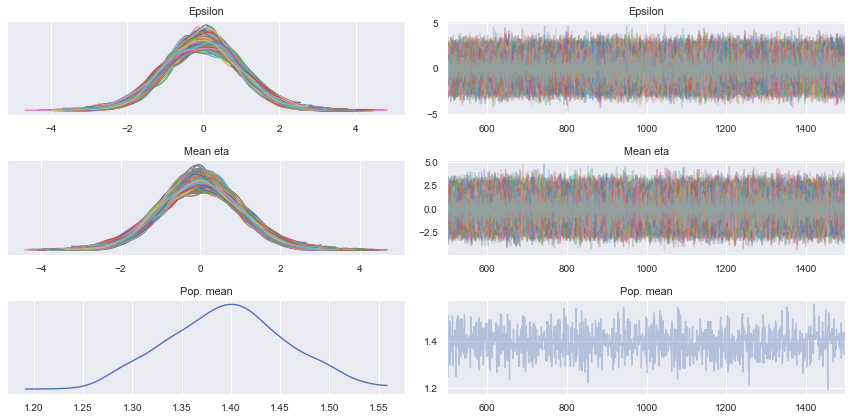

In [11]:
n_samples = 1000
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    gaussian_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [13]:
gaussian_kde_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_gaussian_model_gaussian_kde_filter_1000.nc')

### 4. Rank matching Gaussian KDE filter likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     4      0.25     1        0:00.0
1     5      0.25     1        0:00.0
2     6      0.25     1        0:00.0
3     13     0.5      4        0:00.0
20    688    0.735    38       0:00.2


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


40    1212   0.759    25       0:00.3
60    1516   0.755    15       0:00.4
80    1826   0.753    15       0:00.5
100   2245   0.734    20       0:00.6
120   2637   0.7406   19       0:00.7
140   2909   0.748783 13       0:00.7
160   3278   0.7      18       0:00.8
180   3772   0.782    24       0:00.9
200   4226   0.735    22       0:01.0
220   4562   0.776    16       0:01.1
240   4916   0.757    17       0:01.1
260   5353   0.713    21       0:01.2
280   5753   0.761    20       0:01.3
300   6137   0.72936  19       0:01.4
320   6507   0.772    18       0:01.5
340   6783   0.75     14       0:01.5
360   7081   0.76     15       0:01.6
380   7373   0.74     14       0:01.6
400   7661   0.776    14       0:01.7
420   7925   0.762    13       0:01.8
440   8171   0.756    12       0:01.8
460   8415   0.728    12       0:01.9
480   8675   0.758    13       0:01.9
500   9141   0.75     23       0:02.0
520   9665   0.815    25       0:02.1
540   10109  0.865    22       0:02.2
560   10597 

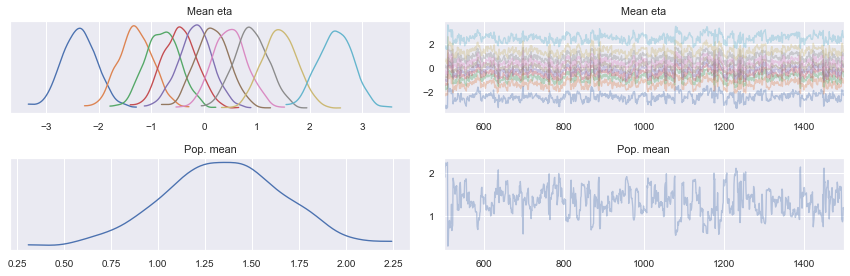

In [139]:
n_samples = 10
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
# log_prior = pints.ComposedLogPrior(*[
#     pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
#     pints.GaussianLogPrior(mean=0, sd=4)])
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.2      2        0:00.0
1     8      0.25     1        0:00.0
2     9      0.25     1        0:00.0
3     16     0.5      4        0:00.0


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    551    0.761    30       0:00.4
40    1479   0.739    45       0:00.9
60    2092   0.752    30       0:01.2
80    2749   0.773    32       0:01.6
100   3383   0.742    31       0:01.9
120   3724   0.713    17       0:02.1
140   4024   0.768    15       0:02.3
160   4347   0.7      16       0:02.5
180   4783   0.753    21       0:02.7
200   5134   0.77     17       0:02.9
220   5413   0.759    14       0:03.1
240   5733   0.749    16       0:03.2
260   5953   0.73     11       0:03.3
280   6225   0.763    13       0:03.5
300   6445   0.739    11       0:03.6
320   6685   0.767    12       0:03.7
340   6897   0.759    11       0:03.9
360   7125   0.764    11       0:04.0
380   7337   0.749    11       0:04.1
400   7517   0.769    9        0:04.2
420   7760   0.734    12       0:04.3
440   7964   0.773    10       0:04.4
460   8201   0.714    12       0:04.6
480   8498   0.766531 15       0:04.7
500   8806   0.754    15       0:04.9
520   9106   0.841    15       0:05.1
540   9406  

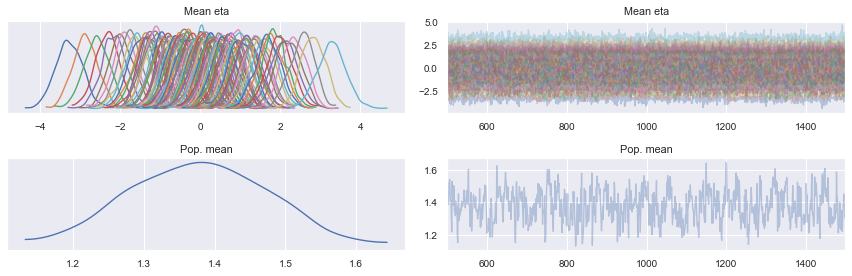

In [140]:
n_samples = 100
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.0
2     7      0.25     1        0:00.0
3     8      0.25     1        0:00.1


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    1423   0.758    79       0:05.4
40    3208   0.753    85       0:13.0
60    5308   0.727    100      0:20.9
80    7032   0.782    83       0:28.8
100   8599   0.759    75       0:35.1
120   8963   0.708    18       0:36.7
140   9383   0.753    20       0:38.6
160   9685   0.732404 15       0:39.9
180   10065  0.762    19       0:41.9
200   10405  0.754    17       0:43.2
220   10761  0.748    17       0:44.6
240   11061  0.769    15       0:45.8
260   11353  0.714    14       0:46.9
280   11733  0.76     19       0:48.9
300   12033  0.752    15       0:50.0
320   12453  0.749    20       0:51.6
340   12833  0.751    19       0:53.1
360   13133  0.771    15       0:54.3
380   13513  0.76     19       0:55.7
400   13829  0.752    16       0:57.5
420   14129  0.742    15       0:58.7
440   14461  0.755    16       0:59.9
460   14743  0.713    14       1:01.1
480   15187  0.772    22       1:03.7
500   15527  0.753    17       1:04.9
520   15827  0.804    15       1:06.0
540   16127 

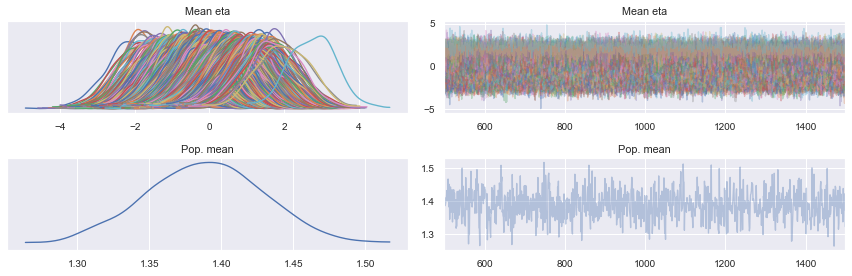

In [145]:
n_samples = 1000
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

### 5. Data-centric KDE log-likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     6      0.5      2        0:00.0
1     7      0.25     1        0:00.0
2     8      0.25     1        0:00.0
3     11     0.5      2        0:00.0


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    606    0.738021 34       0:00.2
40    1460   0.761    41       0:00.5
60    2422   0.754031 46       0:00.8
80    3298   0.754632 42       0:01.0
100   4134   0.765    40       0:01.2
120   5104   0.718    47       0:01.4
140   5574   0.763    23       0:01.5
160   5941   0.711    18       0:01.6
180   7269   0.744    64       0:02.0
200   8085   0.755    39       0:02.1
220   8701   0.749    30       0:02.3
240   9251   0.752    27       0:02.4
260   9810   0.731    27       0:02.6
280   10724  0.746    44       0:02.8
300   11142  0.767198 20       0:02.9
320   11880  0.747    36       0:03.1
340   12212  0.746    16       0:03.2
360   12852  0.782    31       0:03.3
380   13466  0.74     30       0:03.5
400   14296  0.777    40       0:03.7
420   14934  0.742    31       0:03.8
440   15852  0.763    44       0:04.0
460   16465  0.722841 29       0:04.2
480   17179  0.775    34       0:04.4
500   17987  0.756374 39       0:04.5
520   18899  0.855    44       0:04.8
540   19611 

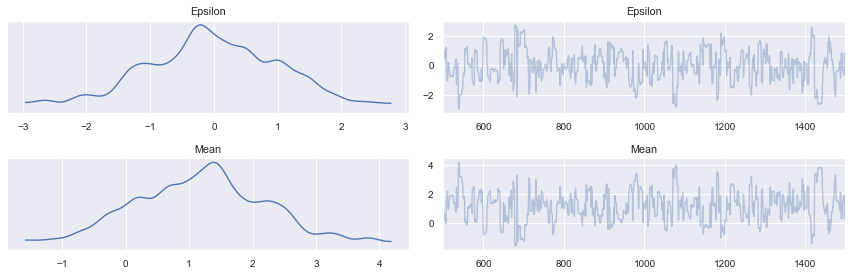

In [106]:
n_samples = 1
log_likelihood = DataCentricGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_samples + [
    pints.GaussianLogPrior(0, 1)] * n_samples)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
data_centric_gaussian_kde_filter_posterior_1 = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    data_centric_gaussian_kde_filter_posterior_1.sel(
        draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

## Comparison to analytic posterior

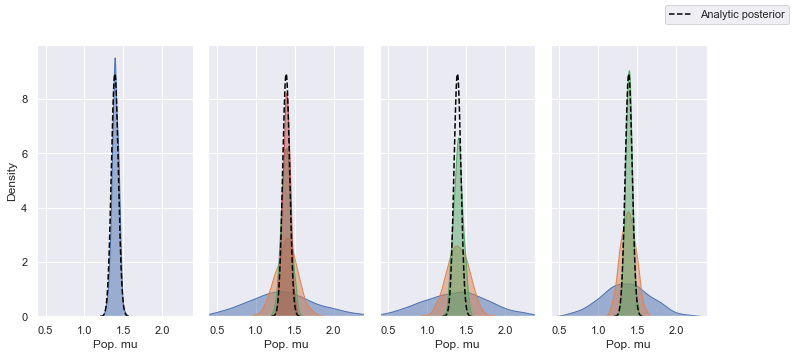

In [147]:
# Get true distribution
n = len(data)
posterior_var = 16 / (1 + n * 8)
posterior_mean = posterior_var * n * np.mean(data) / 2
mus = np.linspace(1.2, 1.6, num=200)
true_pdf = scipy.stats.norm(posterior_mean, np.sqrt(posterior_var)).pdf(mus)

# Create figure
fig, axes = plt.subplots(
    1, 4, figsize=(12, 5), sharey='row', sharex='row')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
axes[0].set_xlim([posterior_mean - 1, posterior_mean + 1])
axes[0].set_xlabel('Pop. mu')
axes[1].set_xlabel('Pop. mu')
axes[2].set_xlabel('Pop. mu')
axes[3].set_xlabel('Pop. mu')
colors = sns.color_palette()

# Plot exact likelihood inference
warmup = 500
thinning = 1
mu_samples = exact_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0],
    palette=colors[0], legend=False)

# Plot Gaussian filter posteriors
warmup = 1000
thinning = 1
mu_samples = gaussian_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[2], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_10000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[3], legend=False)

# Plot KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[1], legend=False)

# Plot RMG KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
    palette=colors[1], legend=False)

# Overlay exact posterior
axes[0].plot(
    mus, true_pdf, color='black', linestyle='--', label='Analytic posterior')
axes[1].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[2].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[3].plot(
    mus, true_pdf, color='black', linestyle='--')

fig.legend()
plt.show()

## Comparison to true population distribution

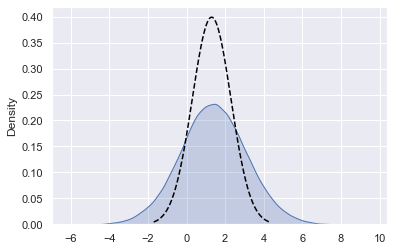

In [103]:
# Get true population distribution
n = len(data)
pop_mu, pop_sigma = true_parameters[:2]
mus = np.linspace(pop_mu - 3 * pop_sigma, pop_mu + 3 * pop_sigma, num=200)
true_pdf = scipy.stats.norm(pop_mu, pop_sigma).pdf(mus)

# Visualise results
# Plot inferred population model
# samples = data_centric_gaussian_kde_filter_posterior_1.sel(
#         draw=slice(warmup, n_iterations)).Mean.values[0].flatten()
# sns.kdeplot(x=samples, fill=True)

# samples = data_centric_gaussian_kde_filter_posterior_10.sel(
#         draw=slice(warmup, n_iterations)).Mean.values[0].flatten()
# sns.kdeplot(x=samples, fill=True)

samples = data_centric_gaussian_kde_filter_posterior_100.sel(
        draw=slice(warmup, n_iterations)).Mean.values[0].flatten()
sns.kdeplot(x=samples, fill=True)

# Plot true population model
ax = plt.plot(
    mus, true_pdf, color='black', linestyle='--',
    label='True population distribution')

plt.show()

#### Test with more data points

Using Haario adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.0
1     2      0.5        0:00.0
2     3      0.333      0:00.1
3     4      0.5        0:00.1
20    21     0.619      0:00.4
40    41     0.78       0:00.6
60    61     0.82       0:00.9
80    81     0.802      0:01.2
100   101    0.802      0:01.5
120   121    0.81       0:01.7
140   141    0.837      0:02.0
160   161    0.857      0:02.3
180   181    0.873      0:02.5
Initial phase completed.
200   201    0.886      0:02.8
220   221    0.855      0:03.1
240   241    0.817      0:03.3
260   261    0.785      0:03.6
280   281    0.751      0:03.9
300   301    0.717608   0:04.1
320   321    0.704      0:04.4
340   341    0.683      0:04.7
360   361    0.657      0:04.9
380   381    0.635      0:05.1
400   401    0.611      0:05.3
420   421    0.606      0:05.6
440   441    0.592      0:05.8
460   461    0.579      0:06.0
480   481    0.563  

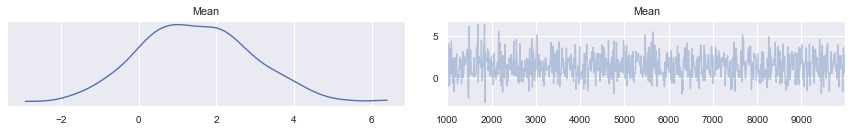

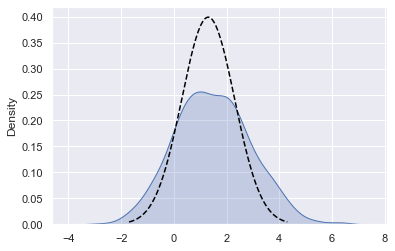

In [86]:
np.random.seed(42)
n_ids = 100000
n_samples_per_id = 1
true_parameters = [1.3, 1, 1]  # pop mean, pop std., noise
means = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids)
more_data = np.empty(shape=(n_ids, n_samples_per_id))
for ids, mean in enumerate(means):
    more_data[ids] = np.random.normal(
    loc=mean, scale=true_parameters[2], size=n_samples_per_id)

log_likelihood = DataCentricGaussianKDEFilterLogLikelihood(
    observations=data, use_percentiles=True, max_n_eps=1000)
# log_prior = pints.ComposedLogPrior(*[
#     pints.UniformLogPrior(-10, 10),
#     pints.GaussianLogPrior(0, 1)])
log_prior = pints.UniformLogPrior(-10, 10)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
# controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 10000
data_centric_gaussian_kde_filter_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 1000
thinning = 10
az.plot_trace(
    data_centric_gaussian_kde_filter_posterior.sel(
        draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()
plt.show()

# Get true population distribution
pop_mu, pop_sigma = true_parameters[:2]
mus = np.linspace(pop_mu - 3 * pop_sigma, pop_mu + 3 * pop_sigma, num=200)
true_pdf = scipy.stats.norm(pop_mu, pop_sigma).pdf(mus)

# Visualise results
ax = plt.plot(
    mus, true_pdf, color='black', linestyle='--',
    label='True population distribution')
samples = data_centric_gaussian_kde_filter_posterior.sel(
        draw=slice(warmup, n_iterations, thinning)).Mean.values[0]
sns.kdeplot(
    x=samples, fill=True)

plt.show()